In [1]:
import pathlib
import pickle

import astropy.coordinates as coord
from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gala.coordinates as gc

from jax.config import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import jax.scipy as jsci

import numpyro
from numpyro_ext.optim import optimize
numpyro.enable_x64()
from numpyro.distributions import TruncatedNormal
from numpyro.infer import MCMC, NUTS, Predictive

from numpyro_ext.optim import optimize

from pyia import GaiaData

import scipy.optimize as sco
import scipy.interpolate as sci
import scipy.stats as scs
import scipy.ndimage as scn
import scipy.special as scsp

from stream_membership import SplineDensityMixtureModel
from stream_membership.helpers import two_truncated_normal_mixture, two_normal_mixture
from gd1_helpers.membership import GD1BackgroundModel, GD1StreamModel
from gd1_helpers.membership.initialize import BackgroundInitializer, StreamInitializer

In [2]:
data_path = pathlib.Path('../data').resolve().absolute()
cache_path = pathlib.Path('../cache').resolve().absolute()

See: `3-Initial-stream-track.ipynb`

In [3]:
g = GaiaData(data_path / 'gd1-GaiaDR3-PS1DR2-joined.fits')

phi1_lim = GD1StreamModel.coord_bounds['phi1']
phi2_mask = (
    (g.gd1_phi2 > -7) & 
    (g.gd1_phi2 < 5) & 
    (g.gd1_phi1 > phi1_lim[0]) & 
    (g.gd1_phi1 < phi1_lim[1])
)
g = g[phi2_mask]

len(g)

6520791

In [4]:
masks = at.Table.read(cache_path / 'init-masks.fits')[phi2_mask]
masks['G19.5'] = g.phot_g_mean_mag < 19.5*u.mag

In [5]:
with open(data_path / 'galcen_frame.pkl', 'rb') as f:
    galcen_frame = pickle.load(f)

In [6]:
c = g.get_skycoord(
    distance=coord.Distance(distmod=g.rough_distmod),
    radial_velocity=0*u.km/u.s
)
gd1_frame = gc.GD1Koposov10()
c_gd1 = c.transform_to(gd1_frame)
c_gd1_refl = gc.reflex_correct(c_gd1, galcen_frame)

Note: We use a past distance trend (de Boer paper) to compute initial solar reflex-corrected proper motions, but do a conservative cut using these.

In [7]:
pm_cov = g.get_cov()[:, 3:5, 3:5]
pm_cov_gd1 = gc.transform_pm_cov(c, pm_cov, gd1_frame)

pm1 = c_gd1_refl.pm_phi1_cosphi2.value
pm2 = c_gd1_refl.pm_phi2.value
pm1_err = np.sqrt(pm_cov_gd1[:, 0, 0])
pm2_err = np.sqrt(pm_cov_gd1[:, 1, 1])
del pm_cov, pm_cov_gd1

# masks['pm1_lim'] = (
#     (pm1 > GD1StreamModel.coord_bounds['pm1'][0]) &
#     (pm1 < GD1StreamModel.coord_bounds['pm1'][1])
# )
masks['pm1_lim'] = (
    (pm1 > -15) &
    (pm1 < -1)
)

In [8]:
all_data = {
    'phi1': c_gd1.phi1.degree,
    'phi2': c_gd1.phi2.degree,
    'pm1': pm1,
    'pm1_err': pm1_err,
    'pm2': pm2,
    'pm2_err': pm2_err,
}

for k, v in all_data.items():
    all_data[k] = np.array(v, copy=True, dtype=np.float64)
    assert np.all(np.isfinite(all_data[k]))

In [9]:
run_mask = masks['cmd_ms'] & masks['pm1_lim']

run_data = {
    'phi1': c_gd1.phi1.degree[run_mask],
    'phi2': c_gd1.phi2.degree[run_mask],
    'pm1': pm1[run_mask],
    'pm1_err': pm1_err[run_mask],
    'pm2': pm2[run_mask],
    'pm2_err': pm2_err[run_mask],
}
for k, v in run_data.items():
    run_data[k] = np.array(v, copy=True, dtype=np.float64)
    assert np.all(np.isfinite(run_data[k]))

In [10]:
_base_mask = masks['cmd_ms'] & masks['pm1_lim']

# Background initialization

In [11]:
bkg_mask = _base_mask & ~masks['sky_track']
bkg_g = g[bkg_mask]
bkg_data = {k: v[bkg_mask] for k, v in all_data.items()}

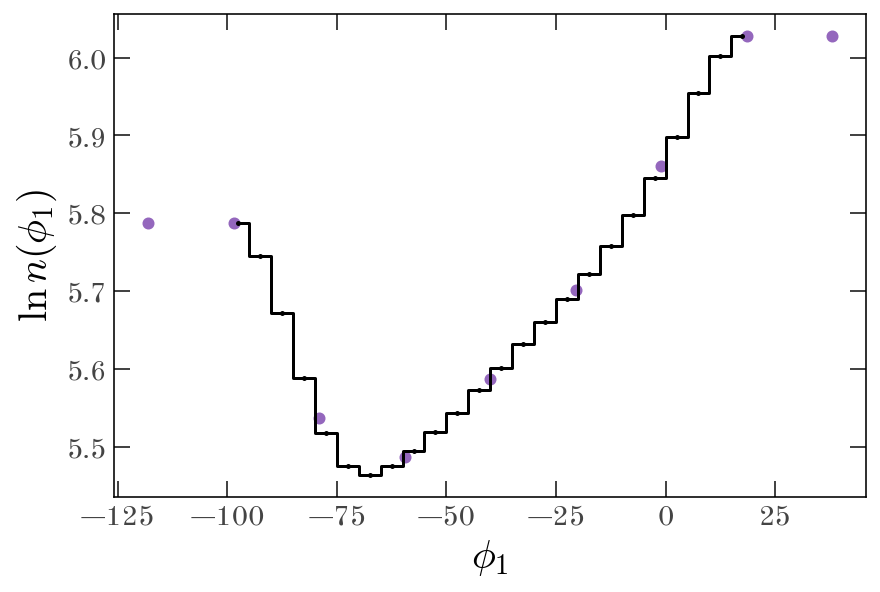

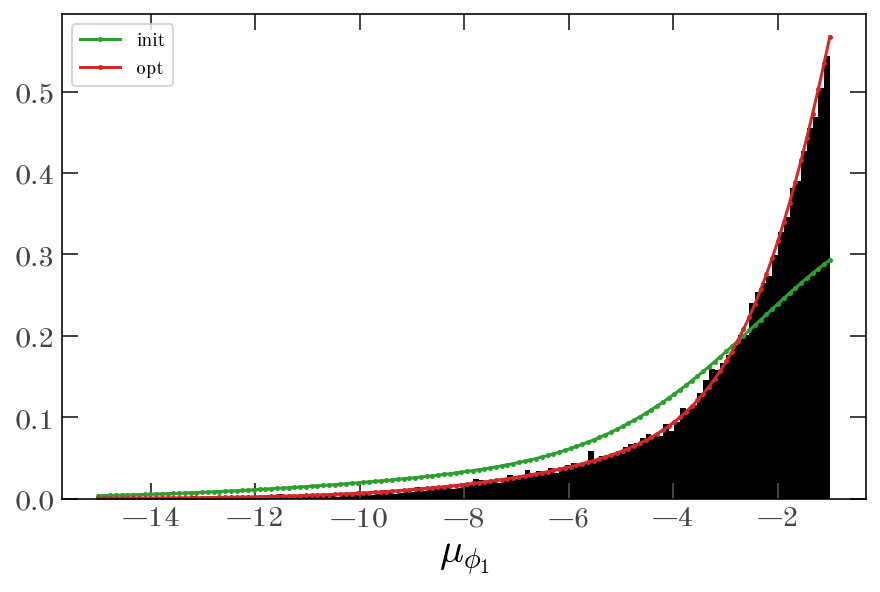

In [12]:
bkg_initter = BackgroundInitializer(bkg_data, plot=True)
bkg_init_p = bkg_initter.init()
bkg_init_p = GD1BackgroundModel.clip_params(bkg_init_p)

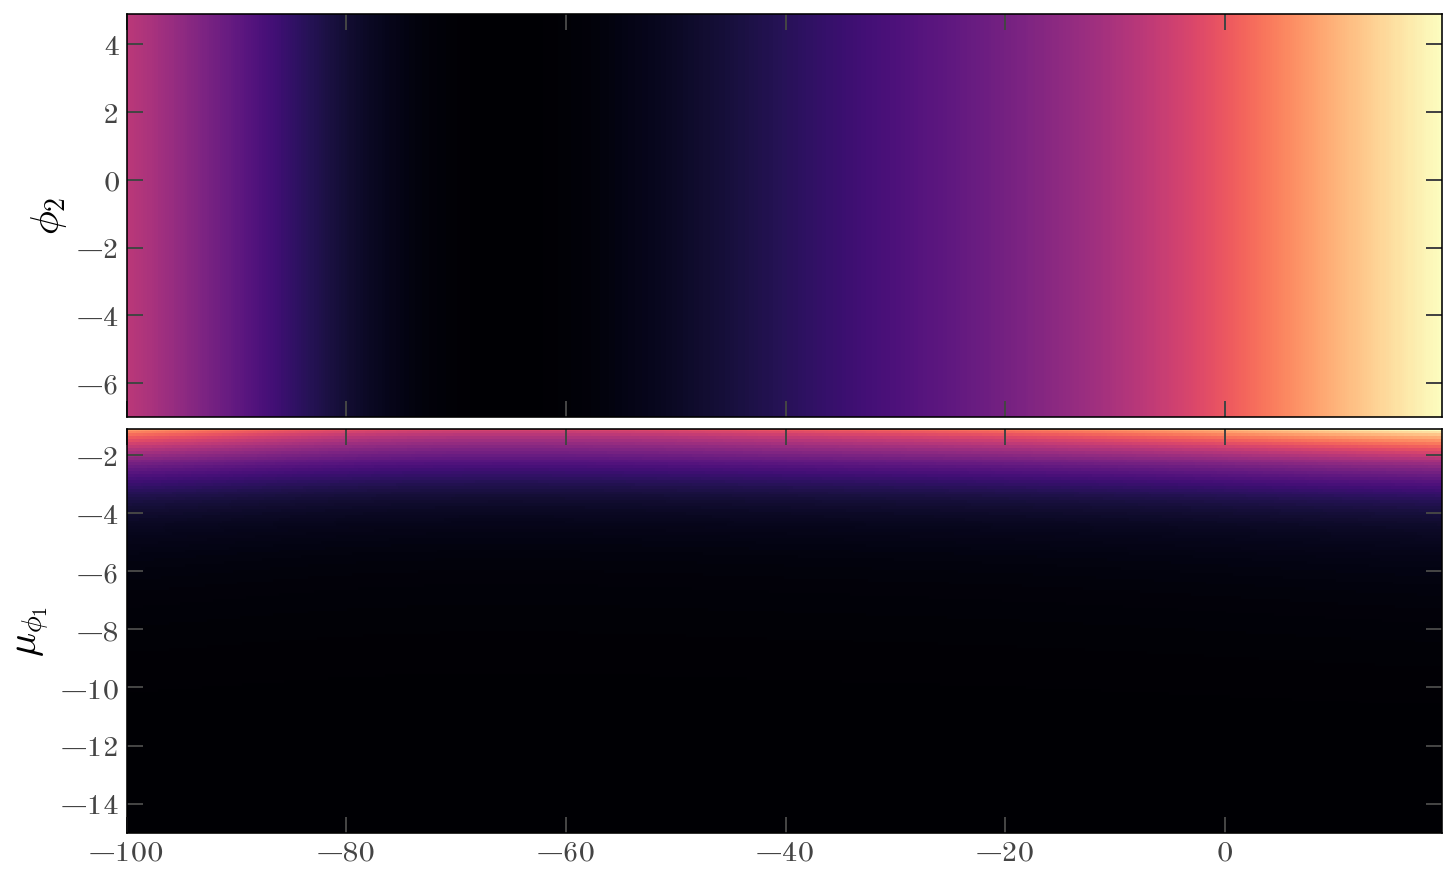

In [13]:
background_init = GD1BackgroundModel(bkg_init_p)
_ = background_init.plot_model_projections()

In [14]:
background_init.ln_likelihood(bkg_data)

DeviceArray(19502.14511871, dtype=float64)

In [15]:
bkg_opt_pars, bkg_info = GD1BackgroundModel.optimize(
    data=bkg_data, init_params=bkg_init_p, use_bounds=False
)
background_opt = GD1BackgroundModel(bkg_opt_pars)

In [16]:
bkg_info

ScipyMinimizeInfo(fun_val=DeviceArray(-0.5871175, dtype=float64, weak_type=True), success=True, status=0, iter_num=276)

In [17]:
# bkg_opt_pars

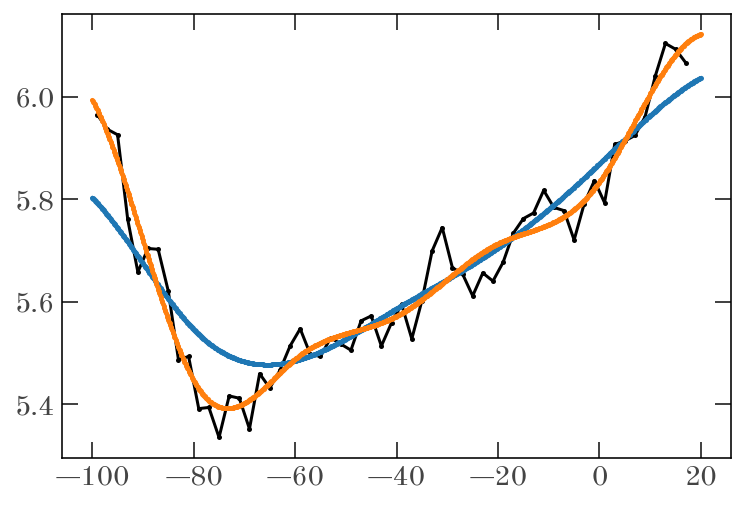

In [18]:
grid = np.linspace(*phi1_lim, 1024)
phi1_bins = np.arange(*GD1BackgroundModel.coord_bounds['phi1'], 2.)
phi1_binc = 0.5 * (phi1_bins[:-1] + phi1_bins[1:])

H, xe = np.histogram(bkg_data['phi1'], bins=phi1_bins)
plt.figure(figsize=(6, 4))
plt.plot(phi1_binc, np.log(H / np.diff(phi1_bins)[0]))

spl = sci.InterpolatedUnivariateSpline(
    GD1BackgroundModel.knots['ln_n0'],
    bkg_init_p['ln_n0'],
    k=GD1BackgroundModel.spline_ks['ln_n0']
)
plt.plot(grid, spl(grid))

spl = sci.InterpolatedUnivariateSpline(
    GD1BackgroundModel.knots['ln_n0'],
    bkg_opt_pars['ln_n0'],
    k=GD1BackgroundModel.spline_ks['ln_n0']
)
plt.plot(grid, spl(grid))

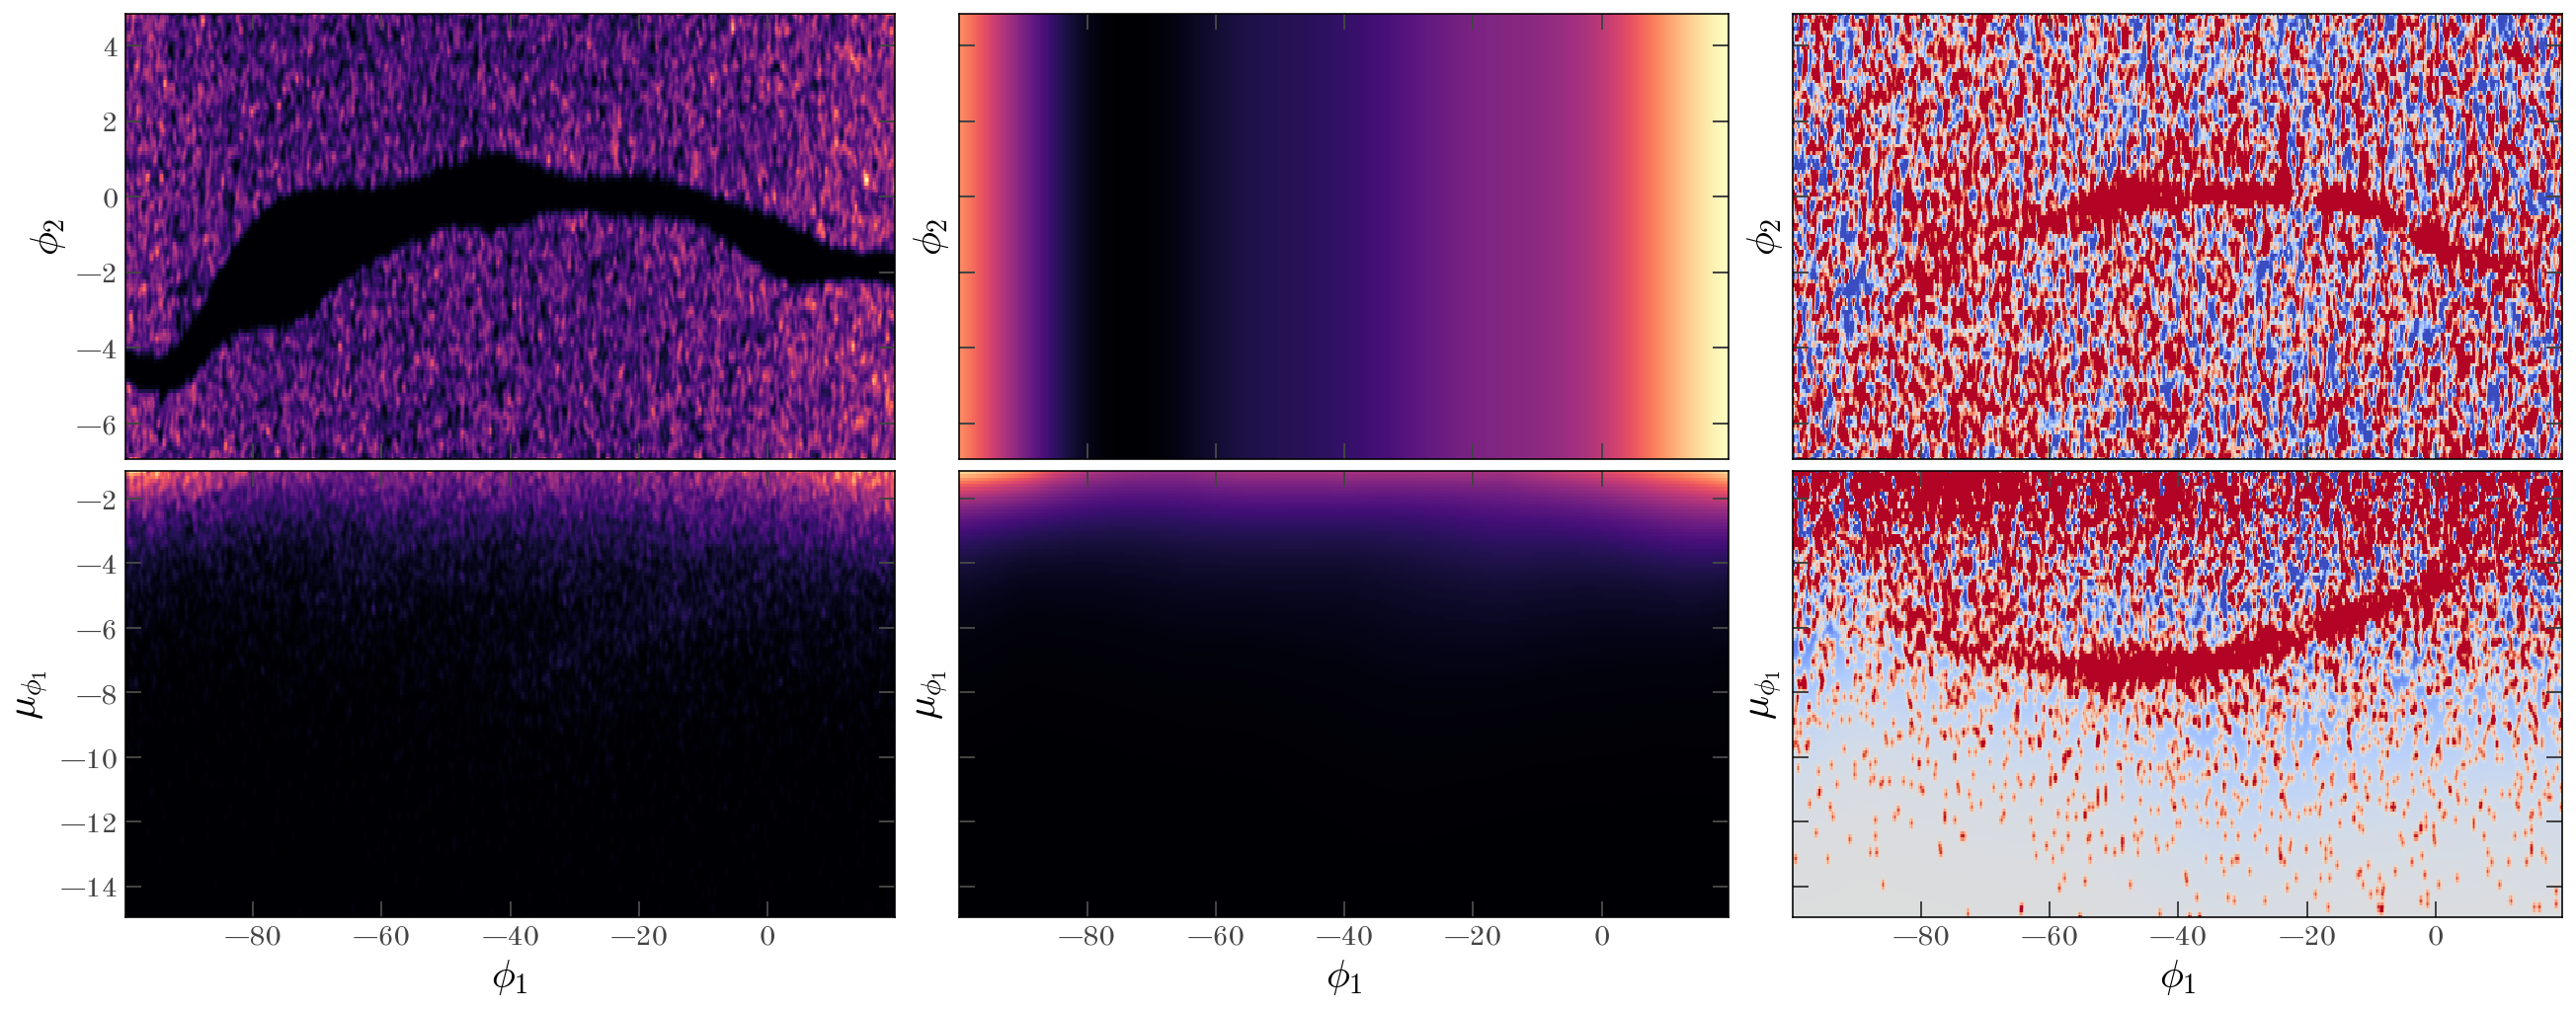

In [19]:
fig, axes = plt.subplots(
    len(background_opt.coord_names), 3, figsize=(18, 3.5 * len(background_opt.coord_names)), 
    sharex=True, sharey='row', constrained_layout=True
)

axes = np.atleast_2d(axes)
background_opt.plot_data_projections(data=bkg_data, axes=axes[:, 0]);
background_opt.plot_model_projections(axes=axes[:, 1]);
background_opt.plot_residual_projections(data=run_data, axes=axes[:, 2])
    
for ax in axes[-1]:
    ax.set_xlabel(r'$\phi_1$')

# Stream Model initialization

In [21]:
stream_mask = _base_mask & masks['sky_track'] & masks['pm_rough']
stream_g = g[stream_mask]
stream_data = {k: v[stream_mask] for k, v in all_data.items()}

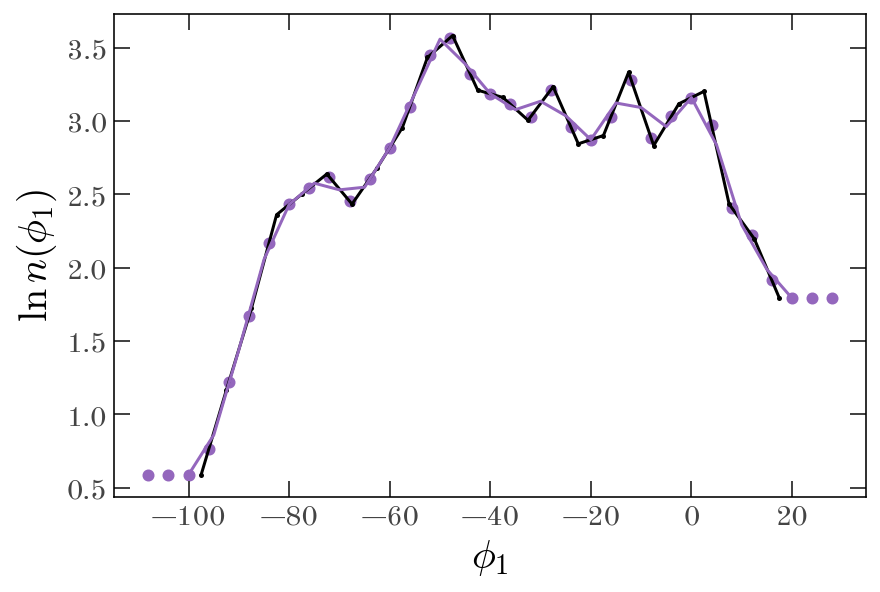

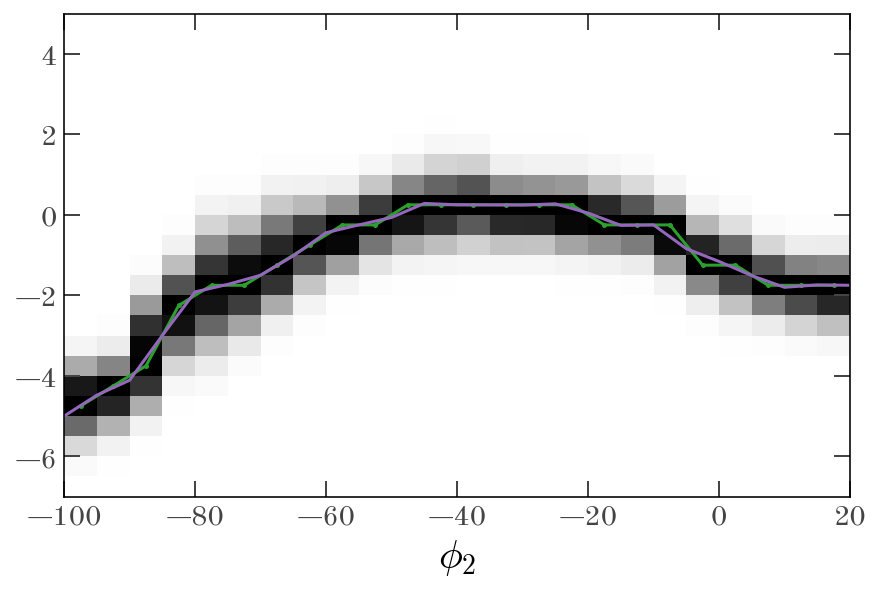

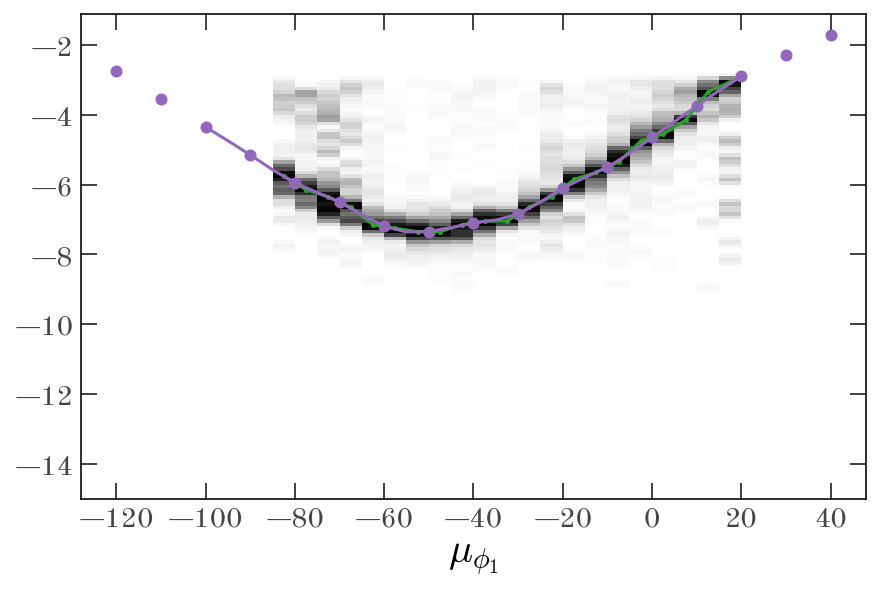

In [22]:
stream_initter = StreamInitializer(stream_data, plot=True)
stream_init_p = stream_initter.init(phi1_bins=np.arange(-85, 20+1e-3, 5))
stream_init_p = GD1StreamModel.clip_params(stream_init_p)

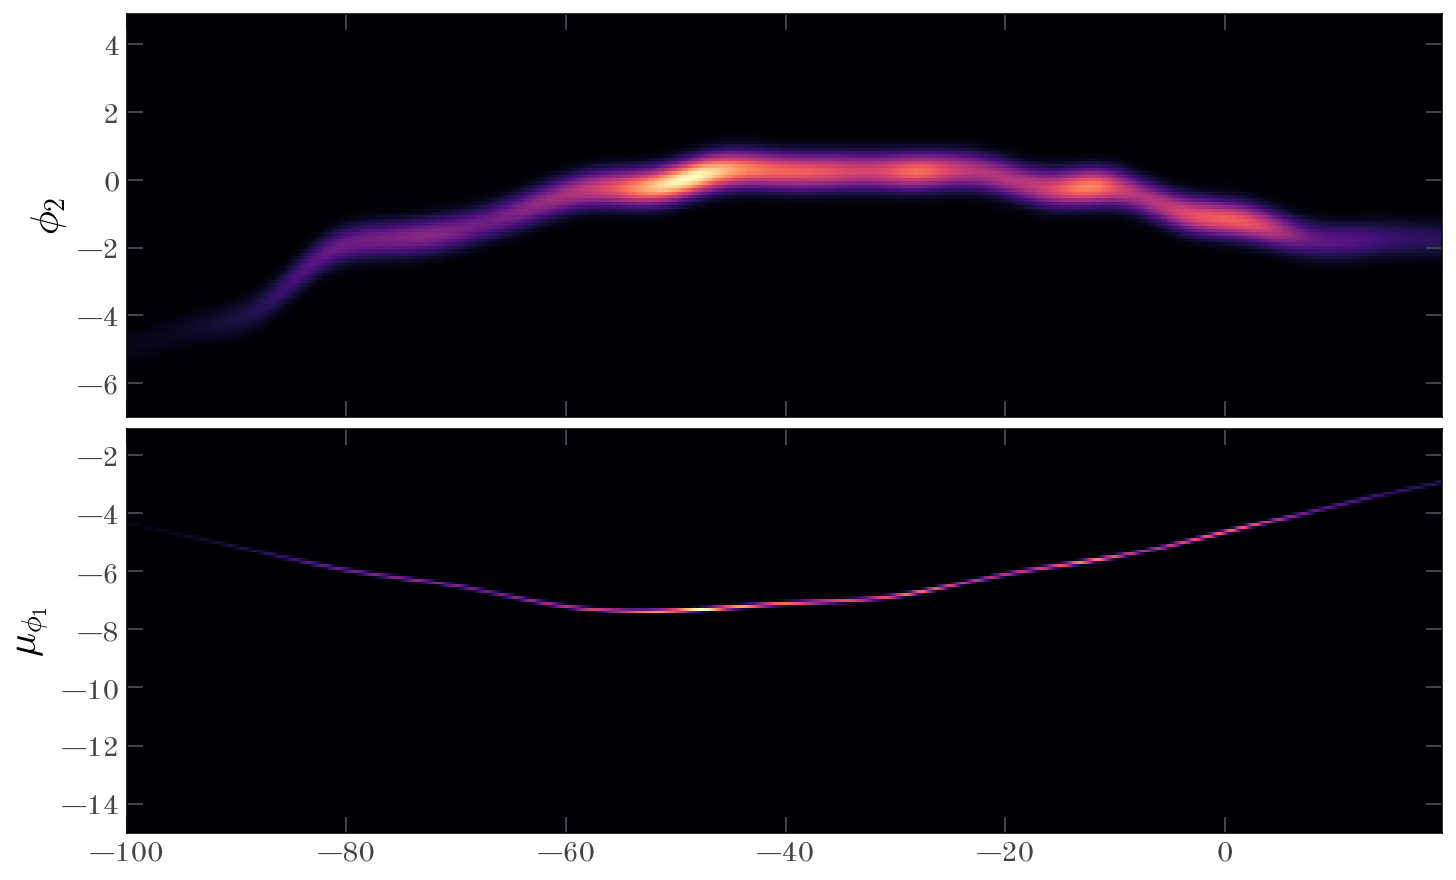

In [23]:
stream_init = GD1StreamModel(stream_init_p)
_ = stream_init.plot_model_projections()

In [24]:
stream_init.ln_likelihood(stream_data)

DeviceArray(-492230.70878736, dtype=float64)

Text(0, 0.5, '$\\phi_2$')

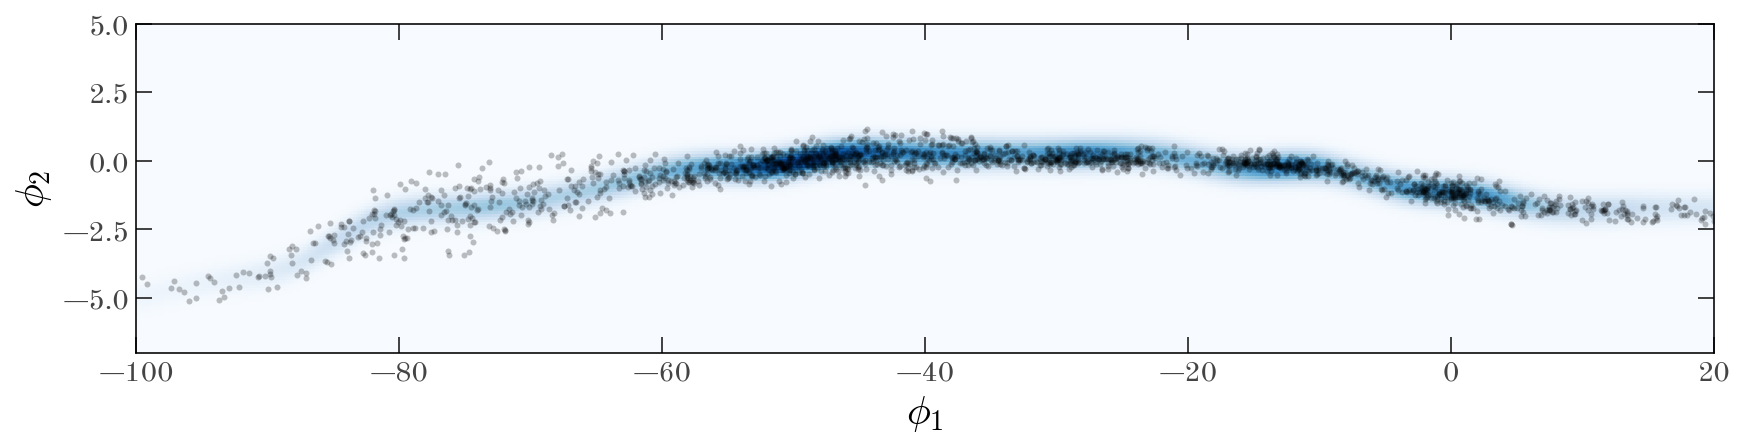

In [25]:
_grids, ln_dens = GD1StreamModel(stream_init_p).evaluate_on_grids()

fig, ax = plt.subplots(figsize=(12, 3), constrained_layout=True)

ax.plot(
    stream_data['phi1'],
    stream_data['phi2'],
    marker="o",
    markeredgewidth=0,
    markersize=3.0,
    ls="none",
    alpha=0.25,
)
ax.pcolormesh(
    _grids['phi2'][0],
    _grids['phi2'][1],
    np.exp(ln_dens['phi2']),
    cmap="Blues",
    shading='auto'
)
ax.set_xlim(-100, 20)
ax.set_ylim(-7, 5)

ax.set_xlabel(r"$\phi_1$")
ax.set_ylabel(r"$\phi_2$")

# Joint model:

In [26]:
init_pars = {}
init_pars[GD1StreamModel.name] = stream_init_p
init_pars[GD1BackgroundModel.name] = bkg_opt_pars

AttributeError: type object 'SplineDensityMixtureModel' has no attribute 'coord_names'

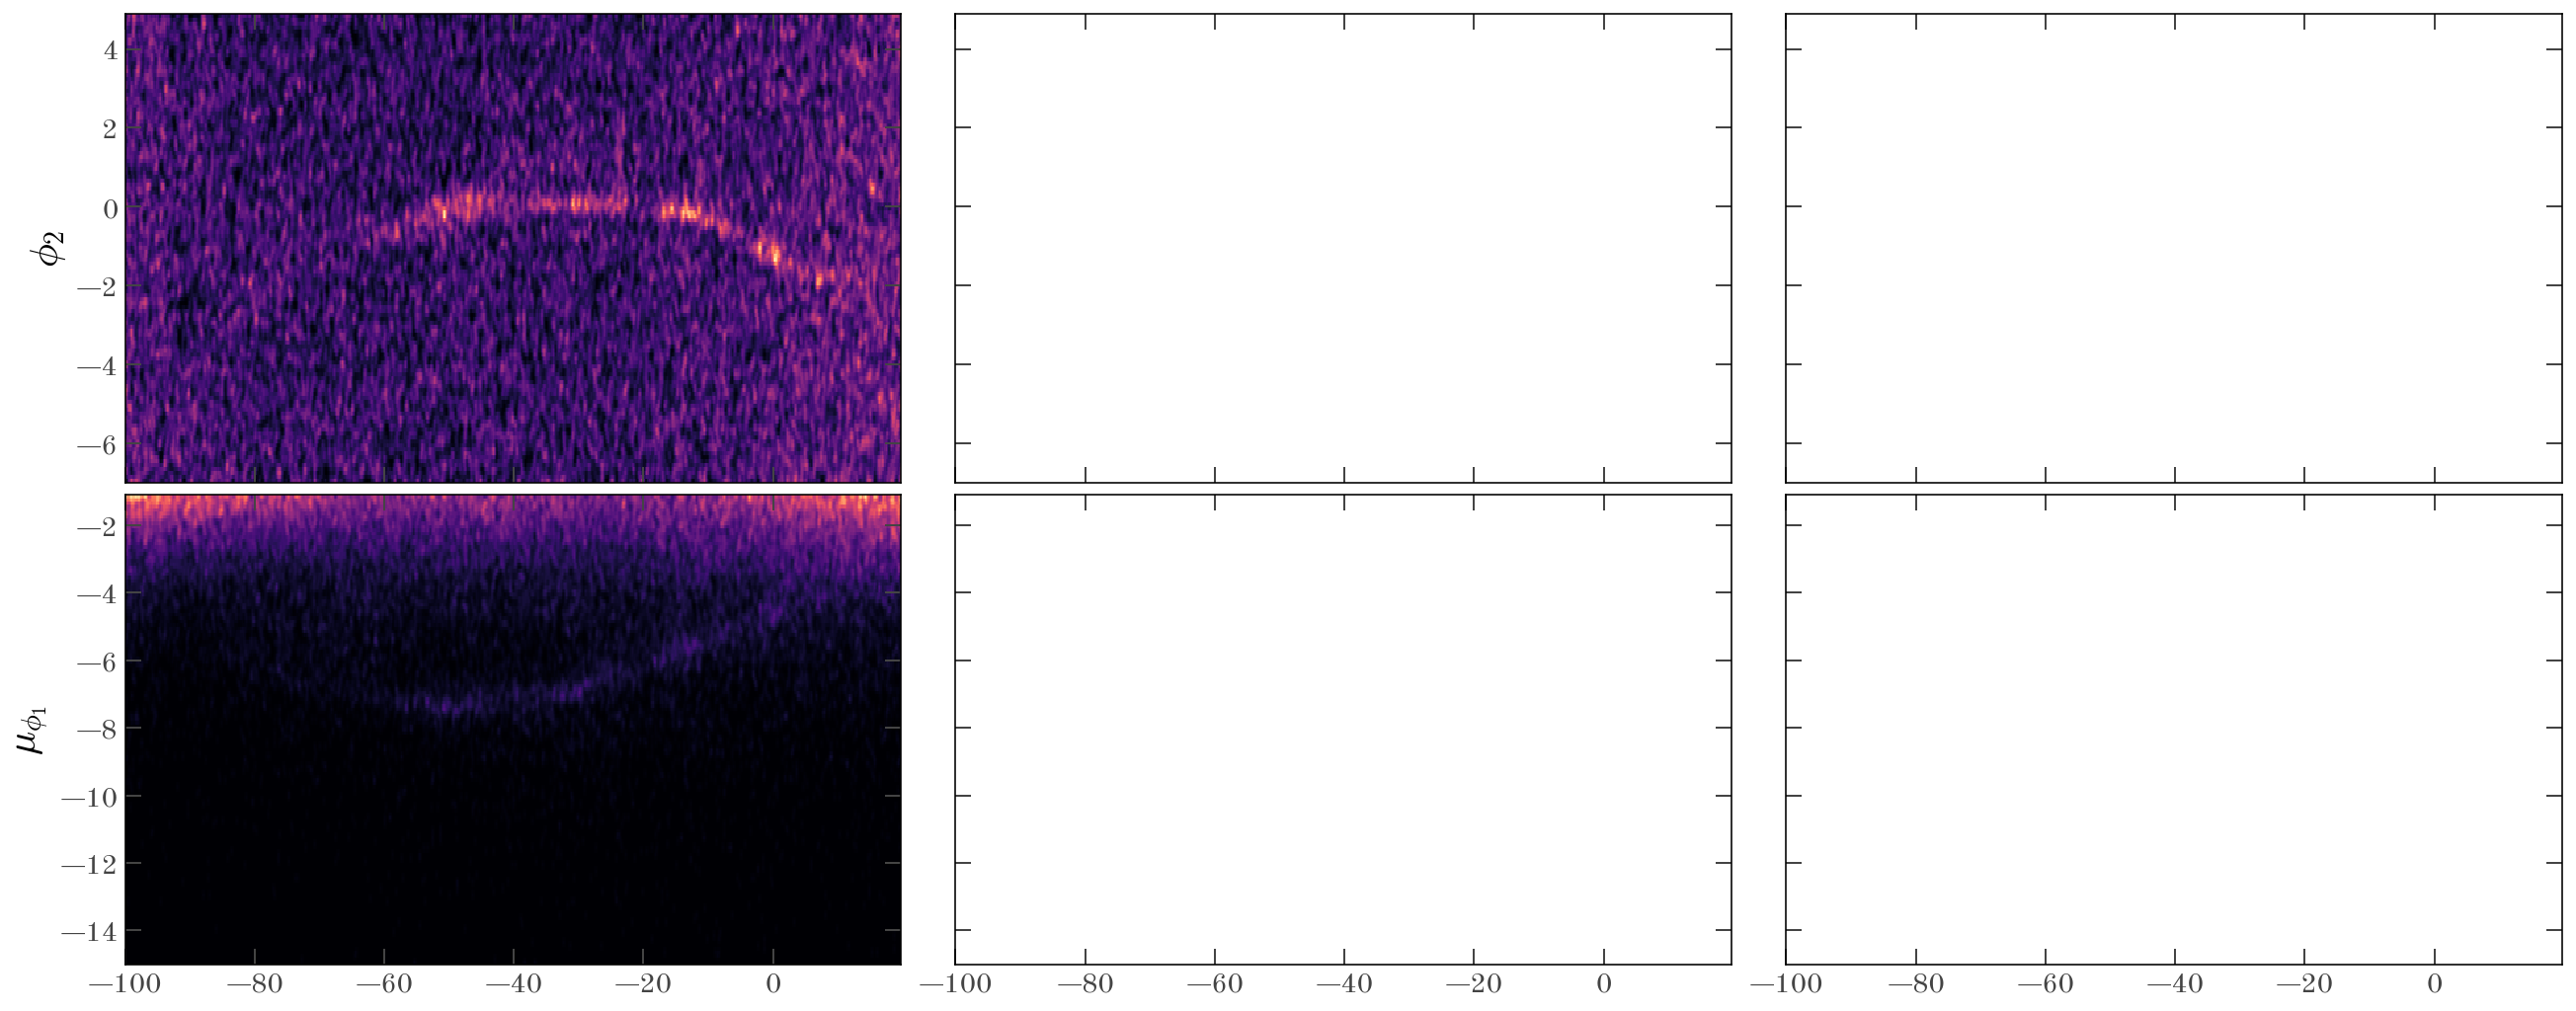

In [28]:
background_init = GD1BackgroundModel(init_pars['background'])
stream_init = GD1StreamModel(init_pars['stream'])
full_model_init = SplineDensityMixtureModel([background_init, stream_init])

fig, axes = plt.subplots(
    len(full_model_init.coord_names), 
    3, 
    figsize=(18, 3.5 * len(full_model_init.coord_names)), 
    sharex=True, sharey='row', constrained_layout=True
)

axes = np.atleast_2d(axes)
GD1StreamModel.plot_data_projections(data=run_data, axes=axes[:, 0]);
full_model_init.plot_model_projections(axes=axes[:, 1]);
full_model_init.plot_residual_projections(data=run_data, axes=axes[:, 2])
    
for ax in axes[-1]:
    ax.set_xlabel(r'$\phi_1$')

## Run optimizer

TODO: run sampler
```
mcmc_kw = dict(
    num_warmup=100,
    num_samples=100,
    num_chains=4,
    chain_method="sequential",
)

mcmc = MCMC(NUTS(SplineDensityMixtureModel.setup_numpyro), **mcmc_kw)
mcmc.run(
    jax.random.PRNGKey(0), 
    Components=Components,
    data=gd1_data,
    init_params=init_pars_chains
)
```

In [29]:
Components = [GD1BackgroundModel, GD1StreamModel]
# Components = [GD1BackgroundModel]
mix_opt_pars, mix_info = SplineDensityMixtureModel.optimize(
    data=run_data, 
    init_params=init_pars, 
    Components=Components,
    use_bounds=False,
    jaxopt_kwargs=dict(maxiter=2048)
)

In [30]:
# mix_opt_pars['stream']

In [31]:
mix_info

ScipyMinimizeInfo(fun_val=DeviceArray(-0.74477835, dtype=float64, weak_type=True), success=True, status=0, iter_num=2011)

In [32]:
full_model_opt = SplineDensityMixtureModel([
    GD1BackgroundModel(mix_opt_pars['background']), 
    GD1StreamModel(mix_opt_pars['stream'])
])

In [33]:
full_model_opt.ln_likelihood(run_data)

DeviceArray(32306.02653955, dtype=float64)

In [34]:
full_model_init.ln_likelihood(run_data)

DeviceArray(29929.23781932, dtype=float64)

(<Figure size 864x648 with 6 Axes>,
 array([[<AxesSubplot: title={'center': 'background'}, ylabel='ln_n0'>,
         <AxesSubplot: title={'center': 'stream'}, ylabel='ln_n0'>],
        [<AxesSubplot: ylabel='phi2'>, <AxesSubplot: ylabel='phi2'>],
        [<AxesSubplot: ylabel='pm1'>, <AxesSubplot: ylabel='pm1'>]],
       dtype=object))

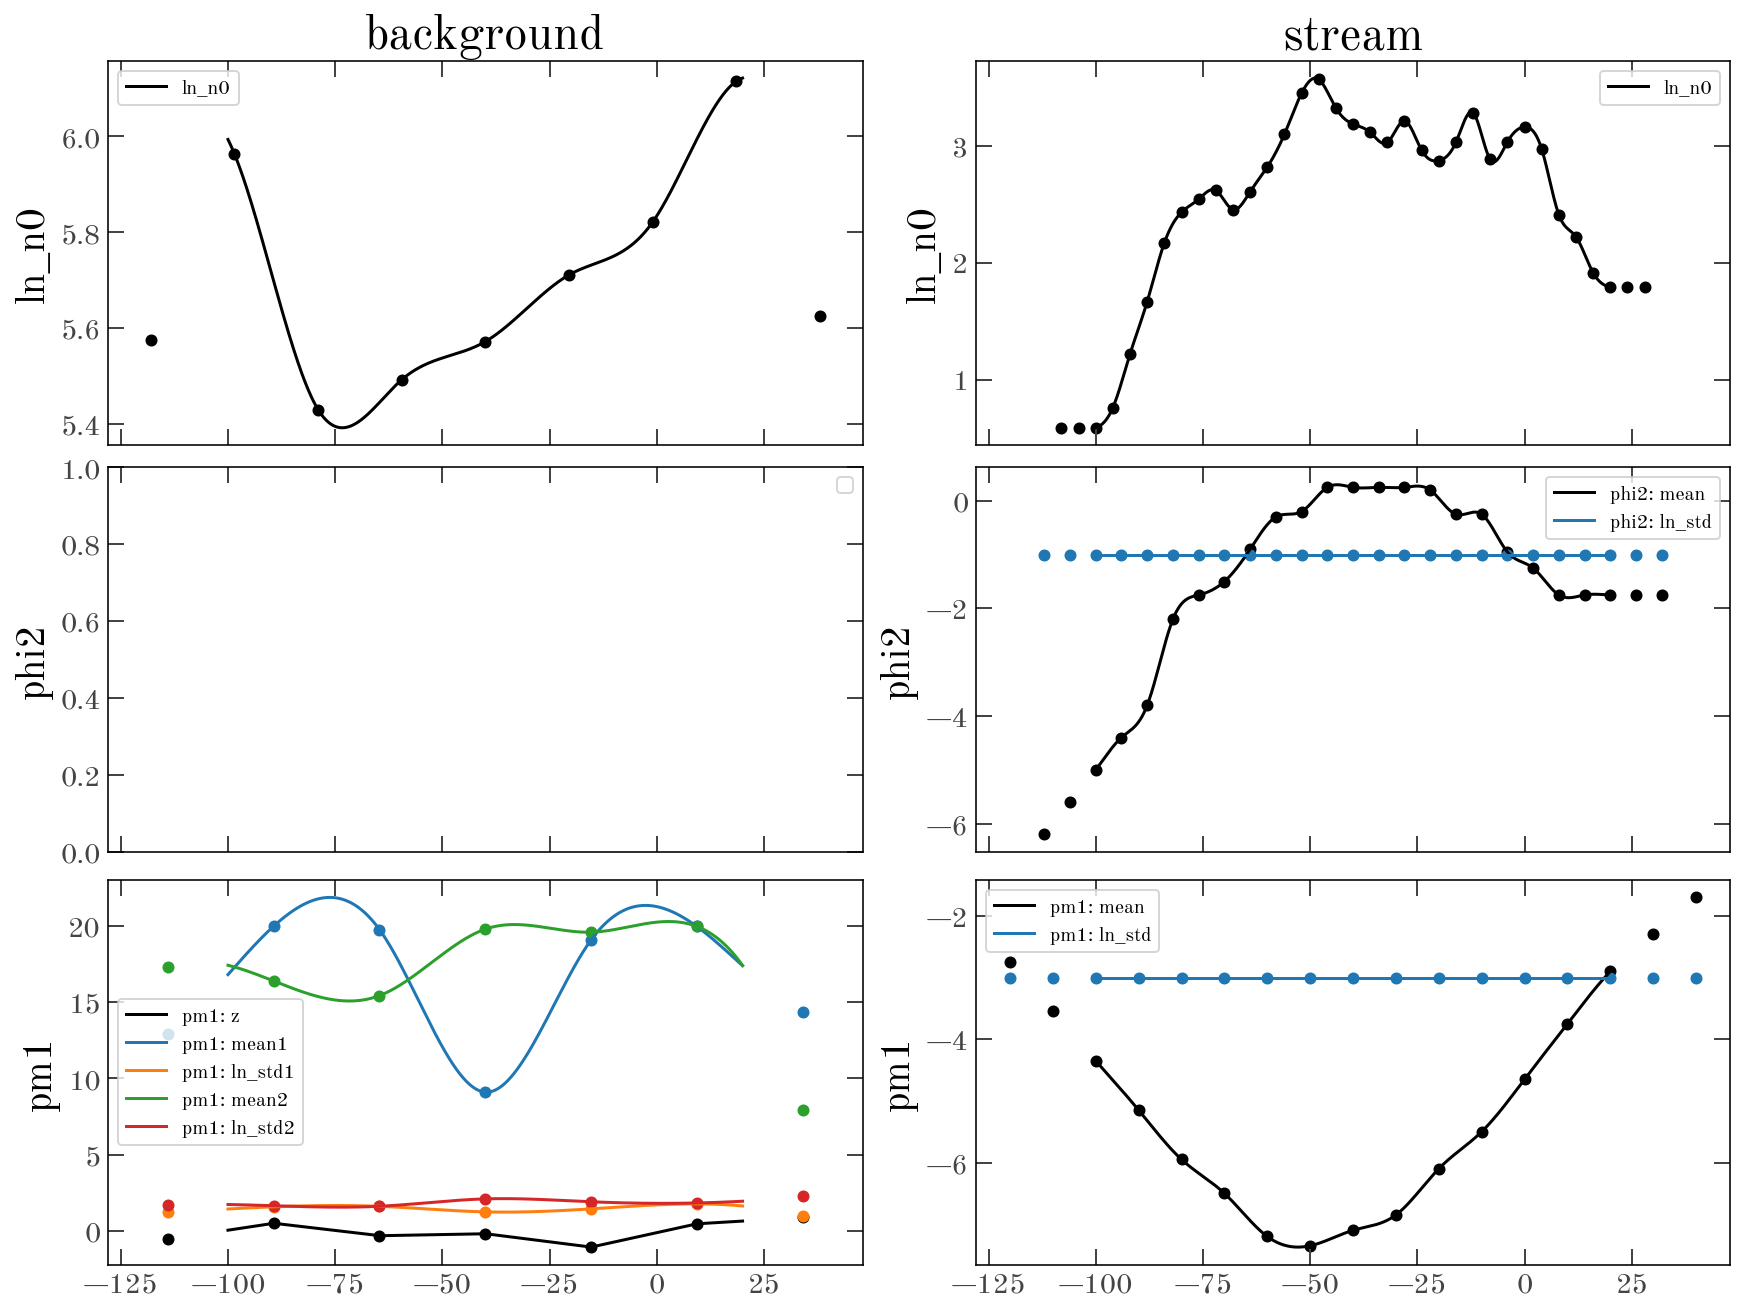

In [35]:
full_model_init.plot_knots()

(<Figure size 864x648 with 6 Axes>,
 array([[<AxesSubplot: title={'center': 'background'}, ylabel='ln_n0'>,
         <AxesSubplot: title={'center': 'stream'}, ylabel='ln_n0'>],
        [<AxesSubplot: ylabel='phi2'>, <AxesSubplot: ylabel='phi2'>],
        [<AxesSubplot: ylabel='pm1'>, <AxesSubplot: ylabel='pm1'>]],
       dtype=object))

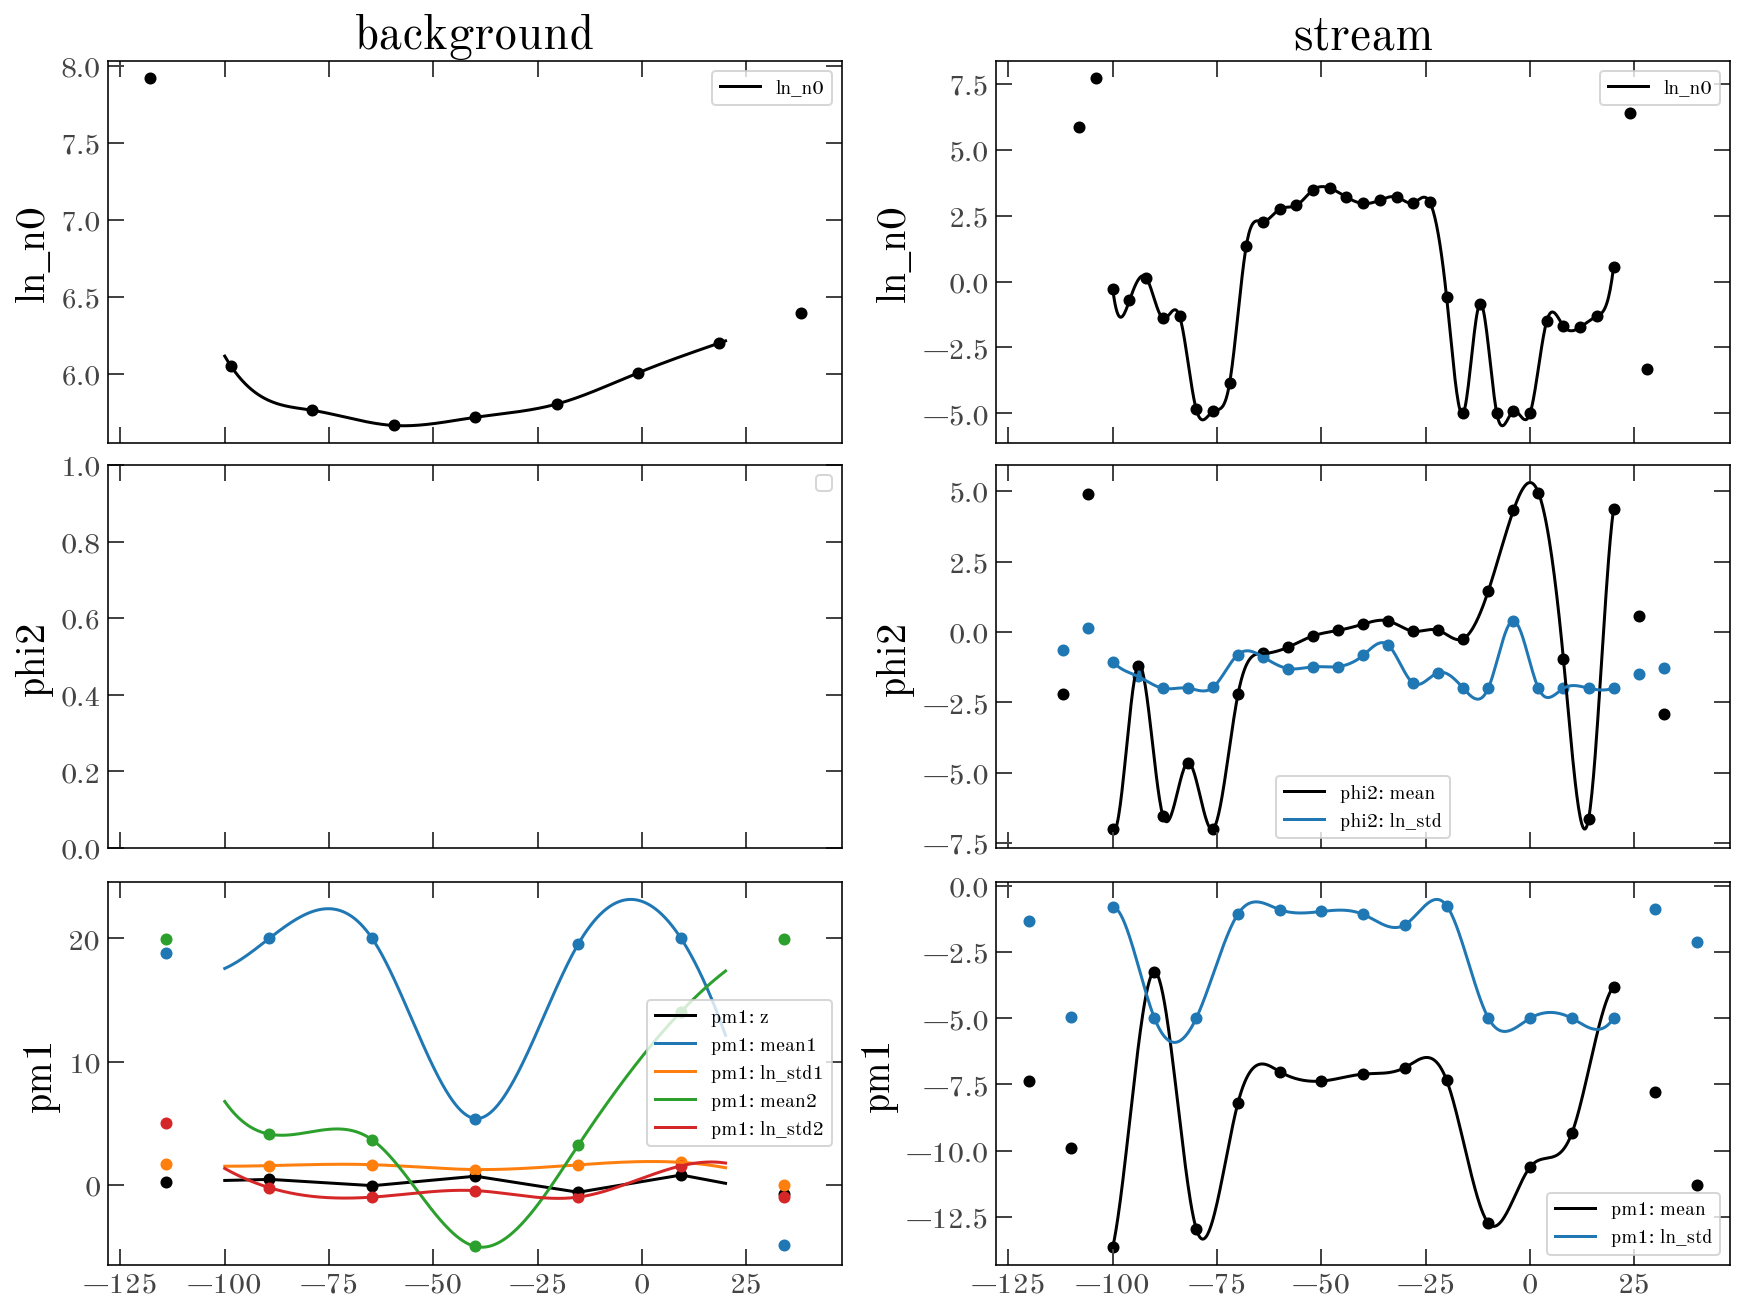

In [36]:
full_model_opt.plot_knots()

AttributeError: type object 'SplineDensityMixtureModel' has no attribute 'coord_names'

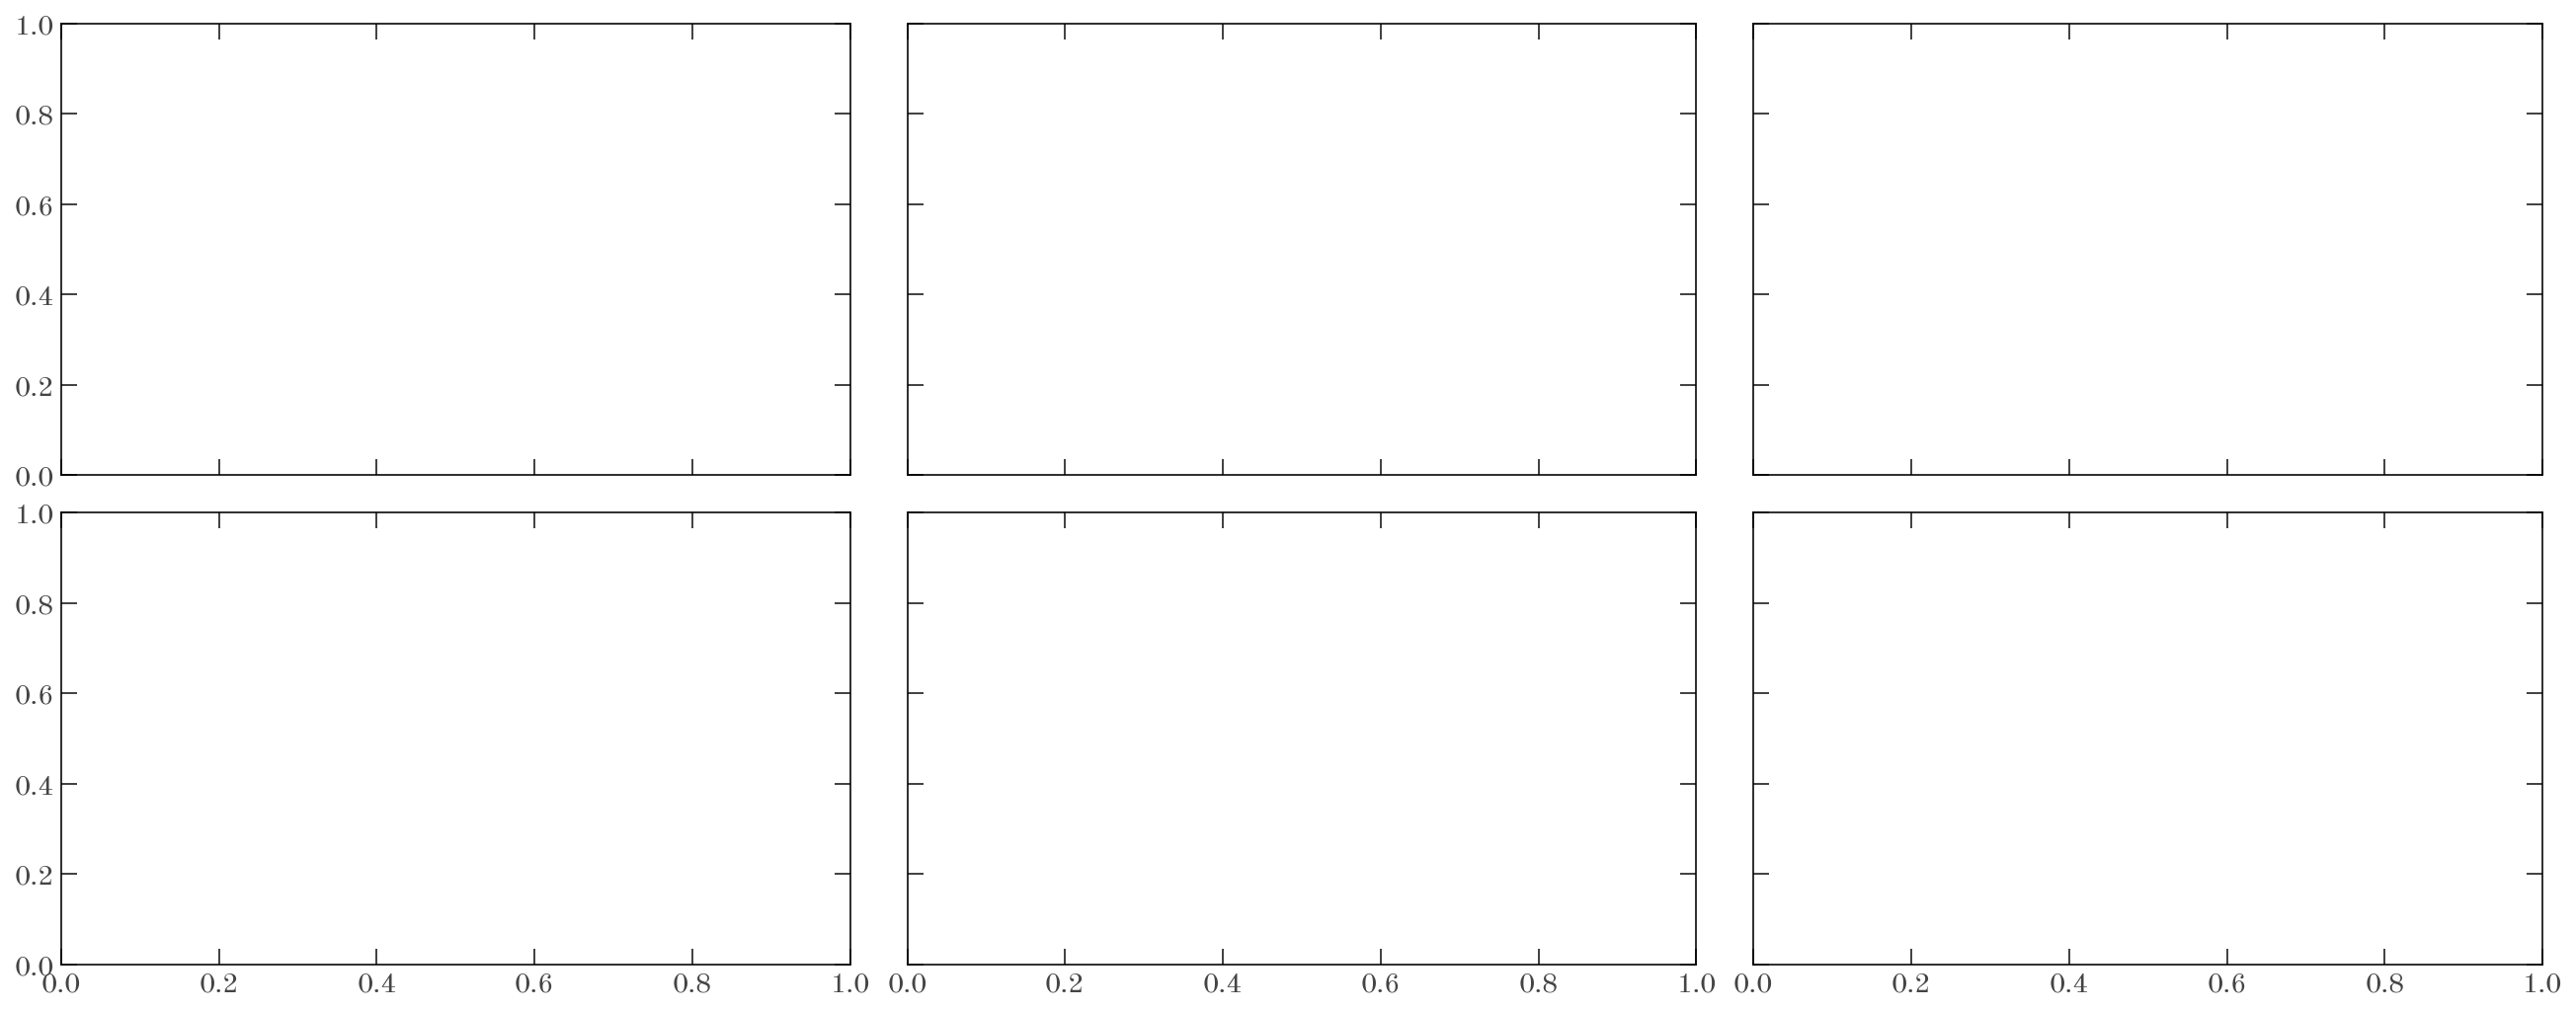

In [37]:
fig, axes = plt.subplots(
    len(full_model_opt.coord_names), 
    3, 
    figsize=(18, 3.5 * len(full_model_opt.coord_names)), 
    sharex=True, sharey='row', constrained_layout=True
)

axes = np.atleast_2d(axes)
full_model_opt.plot_data_projections(data=run_data, axes=axes[:, 0]);
full_model_opt.plot_model_projections(axes=axes[:, 1]);
full_model_opt.plot_residual_projections(data=run_data, axes=axes[:, 2])
    
for ax in axes[-1]:
    ax.set_xlabel(r'$\phi_1$')

## TEST: sampling

In [ ]:
rng = np.random.default_rng(seed=42)

n_chains = 2

init_pars_chains = {}
for C in Components:
    C_pars = init_pars[C.name]
    
    sub = {}
    tmp = C_pars[C.density_name]
    sub[C.density_name] = rng.normal(tmp, 1e-2, size=(n_chains, len(tmp)))
    
    for coord_name in C.coord_names:
        if coord_name not in sub:
            if coord_name not in C_pars or not C_pars[coord_name]:
                continue
            sub[coord_name] = {}
        
        for par_name, tmp in C_pars[coord_name].items():
            sub[coord_name][par_name] = rng.normal(tmp, 1e-2, size=(n_chains, len(tmp)))
    
    init_pars_chains[C.name] = sub

In [ ]:
mcmc_kw = dict(
    num_warmup=100,
    num_samples=100,
    num_chains=n_chains,
    chain_method="sequential",
)

mcmc = MCMC(NUTS(SplineDensityMixtureModel.setup_numpyro), **mcmc_kw)
mcmc.run(
    jax.random.PRNGKey(0), 
    Components=Components,
    data=run_data, 
    init_params=init_pars_chains
)

In [ ]:
mcmc.print_summary()

In [ ]:
samples = mcmc.get_samples()
samples_unpacked = SplineDensityMixtureModel.unpack_params(samples, Components)

In [ ]:
nsamples = 4
fig, axes = plt.subplots(
    nsamples, 2, figsize=(10, nsamples * 2.5), sharex=True, sharey='col', constrained_layout=True
)

rng = np.random.default_rng(32)
for j, i in enumerate(rng.choice(samples['ln_n0_background'].shape[0], size=nsamples)):
    sample_unpacked = SplineDensityMixtureModel.unpack_params(
        {k: v[i] for k, v in samples.items()}, 
        Components
    )
    sample_mixture = SplineDensityMixtureModel([C(sample_unpacked[C.name]) for C in Components])
    sample_mixture.plot_model_projections(axes=axes[j])

In [ ]:
sample_mixture.plot_knots()

In [ ]:
fig, axes = plt.subplots(
    len(sample_mixture.coord_names), 
    3, 
    figsize=(18, 3.5 * len(sample_mixture.coord_names)), 
    sharex=True, sharey='row', constrained_layout=True
)

axes = np.atleast_2d(axes)
sample_mixture.plot_data_projections(data=run_data, axes=axes[:, 0]);
sample_mixture.plot_model_projections(axes=axes[:, 1]);
sample_mixture.plot_residual_projections(data=run_data, axes=axes[:, 2])
    
for ax in axes[-1]:
    ax.set_xlabel(r'$\phi_1$')

# Redefine likelihoods:

In [25]:
import numpyro.distributions as dist
from functools import partial
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline
from stream_membership.helpers import (
    ln_simpson, two_truncated_normal_mixture, two_normal_mixture
)
from gd1_helpers.membership.gd1_model import z_to_w, w_to_z

In [26]:
dx = 1e-2
phi1_grid = jnp.arange(
    GD1BackgroundModel.coord_bounds["phi1"][0], 
    GD1BackgroundModel.coord_bounds["phi1"][1] + dx, 
    dx
)

def ln_likelihood_background(pars, data):
    lls = {}
    
    ln_n0 = InterpolatedUnivariateSpline(
        GD1BackgroundModel.knots['ln_n0'],
        pars['ln_n0'],
        k=GD1BackgroundModel.spline_ks['ln_n0']
    )(data['phi1'])
    
    ln_n_grid = InterpolatedUnivariateSpline(
        GD1BackgroundModel.knots['ln_n0'],
        pars['ln_n0'],
        k=GD1BackgroundModel.spline_ks['ln_n0']
    )(phi1_grid)
    ln_V = ln_simpson(ln_n_grid, phi1_grid)
    
    # no phi2 model, so uniform dist
    lim = GD1BackgroundModel.coord_bounds['phi2']
    lls['phi2'] = jnp.full_like(data['phi1'], - jnp.log(lim[1] - lim[0]))
    
    # pm1
    pm1_pars = {}
    for k, knot_vals in pars['pm1'].items():
        pm1_pars[k] = InterpolatedUnivariateSpline(
            GD1BackgroundModel.knots['pm1'],
            pars['pm1'][k],
            k=GD1BackgroundModel.spline_ks['pm1'][k]
        )(data['phi1'])
    lls['pm1'] = two_truncated_normal_mixture(
        z_to_w(pm1_pars['z']),
        pm1_pars['mean1'],
        pm1_pars['ln_std1'],
        pm1_pars['mean2'],
        pm1_pars['ln_std2'],
        low=GD1BackgroundModel.coord_bounds['pm1'][0],
        high=GD1BackgroundModel.coord_bounds['pm1'][1],
        yerr=data['pm1_err']
    ).log_prob(data['pm1'])
    
    # pm2
    pm2_pars = {}
    for k, knot_vals in pars['pm2'].items():
        pm2_pars[k] = InterpolatedUnivariateSpline(
            GD1BackgroundModel.knots['pm2'],
            knot_vals,
            k=GD1BackgroundModel.spline_ks['pm2'][k]
        )(data['phi1'])
    lls['pm2'] = two_normal_mixture(
        z_to_w(pm2_pars['z']),
        pm2_pars['mean1'],
        pm2_pars['ln_std1'],
        pm2_pars['mean2'],
        pm2_pars['ln_std2'],
        yerr=data['pm2_err']
    ).log_prob(data['pm2'])
    
    return ln_V, ln_n0, lls


def optim_background(pars, data):
    ln_V, ln_n0, lls = ln_likelihood_background(pars, data)
    return - (-jnp.exp(ln_V) + (jnp.array([v for v in lls.values()]).sum(axis=0) + ln_n0).sum()) / len(data['phi1'])

In [28]:
ln_V, ln_n0, lls = ln_likelihood_background(bkg_init_p, bkg_data)
ln_V

DeviceArray(9.66048486, dtype=float64)

In [29]:
def ln_likelihood_stream(pars, data):
    lls = {}
    
    ln_n0 = InterpolatedUnivariateSpline(
        GD1StreamModel.knots['ln_n0'],
        pars['ln_n0'],
        k=GD1StreamModel.spline_ks['ln_n0']
    )(data['phi1'])
    
    ln_n_grid = InterpolatedUnivariateSpline(
        GD1StreamModel.knots['ln_n0'],
        pars['ln_n0'],
        k=GD1StreamModel.spline_ks['ln_n0']
    )(phi1_grid)
    ln_V = ln_simpson(ln_n_grid, phi1_grid)
    
    # phi2
    phi2_pars = {}
    for k, knot_vals in pars['phi2'].items():
        phi2_pars[k] = InterpolatedUnivariateSpline(
            GD1StreamModel.knots['phi2'],
            pars['phi2'][k],
            k=GD1StreamModel.spline_ks['phi2'][k]
        )(data['phi1'])
    lls['phi2'] = dist.Normal(
        loc=phi2_pars['mean'],
        scale=jnp.exp(phi2_pars['ln_std'])
    ).log_prob(data['phi2'])
    
    # pm1
    pm1_pars = {}
    for k, knot_vals in pars['pm1'].items():
        pm1_pars[k] = InterpolatedUnivariateSpline(
            GD1StreamModel.knots['pm1'],
            pars['pm1'][k],
            k=GD1StreamModel.spline_ks['pm1'][k]
        )(data['phi1'])
    lls['pm1'] = dist.Normal(
        pm1_pars['mean'],
        jnp.sqrt(jnp.exp(2 * pm1_pars['ln_std']) + data['pm1_err']**2),
    ).log_prob(data['pm1'])
    
    # pm2
    pm2_pars = {}
    for k, knot_vals in pars['pm2'].items():
        pm2_pars[k] = InterpolatedUnivariateSpline(
            GD1StreamModel.knots['pm2'],
            pars['pm2'][k],
            k=GD1StreamModel.spline_ks['pm2'][k]
        )(data['phi1'])
    lls['pm2'] = dist.Normal(
        pm2_pars['mean'],
        jnp.sqrt(jnp.exp(2 * pm2_pars['ln_std']) + data['pm2_err']**2),
    ).log_prob(data['pm2'])
    
    return ln_V, ln_n0, lls

In [32]:
ln_V, ln_n0, lls = ln_likelihood_stream(stream_init_p, run_data)
assert np.isfinite(lls['phi2']).all()
# ln_V, ln_n0, lls

In [34]:
def ln_likelihood_mixture(pars, data):
    res_bkg = ln_likelihood_background(pars['background'], data)
    res_stream = ln_likelihood_stream(pars['stream'], data)
    
    ln_V = jnp.logaddexp(res_bkg[0], res_stream[0])
    ln_n = jnp.logaddexp(
        res_bkg[1] + res_bkg[2]['phi2'] + res_bkg[2]['pm1'] + res_bkg[2]['pm2'],
        res_stream[1] + res_stream[2]['phi2'] + res_stream[2]['pm1'] + res_stream[2]['pm2']
    )
    
    return ln_V, ln_n

def optim_mixture(pars, data):
    ln_V, ln_n = ln_likelihood_mixture(pars, data)
    return - (-jnp.exp(ln_V) + ln_n.sum())

In [35]:
from numpyro_ext.optim import optimize
from jaxopt import ScipyMinimize, ScipyBoundedMinimize

In [37]:
# optim_background(bkg_init_p, bkg_data)

mix_init_p = {'stream': stream_init_p, 'background': bkg_opt_pars}
optim_mixture(mix_init_p, run_data)

DeviceArray(29866.19783272, dtype=float64)

In [48]:
bkg_l, bkg_h = GD1BackgroundModel._get_jaxopt_bounds()
str_l, str_h = GD1StreamModel._get_jaxopt_bounds()
bounds_l = {'background': bkg_l, 'stream': str_l}
bounds_h = {'background': bkg_h, 'stream': str_h}

In [55]:
optim_mixture(bounds_h, run_data)

DeviceArray(351475.81871197, dtype=float64)

In [49]:
optimizer = ScipyBoundedMinimize(
    method='L-BFGS-B', 
    maxiter=2048,
    options=dict(maxls=10000),
    fun=optim_mixture,
)
opt_step = optimizer.run(
    init_params=mix_init_p, 
    data=run_data,
    bounds=(bounds_l, bounds_h)
)

In [50]:
opt_step.state.success, opt_step.state.iter_num

(False, 0)

In [40]:
opt_step.params['background']

{'V': {'': DeviceArray([], dtype=float64)},
 'extra': {'prior': DeviceArray([], dtype=float64)},
 'ln': {'n': DeviceArray([], dtype=float64)},
 'ln_n0': DeviceArray([ 75.66222789,  13.89446617,   5.69803211,   5.7196521 ,
                5.85825029,   5.88670092,   6.07462943,   2.82845054,
              -19.14005129], dtype=float64),
 'pm1': {'ln_std1': DeviceArray([  1.33881696,   2.51281143,   1.28203969,   2.10326548,
                 2.05021362,  -0.7692249 , -28.05966017], dtype=float64),
  'ln_std2': DeviceArray([-38.18890406, -45.35485998,  -8.88423482,   1.99438864,
                 3.59164102,   4.44617616,   6.1711946 ], dtype=float64),
  'mean1': DeviceArray([274.10403757,  78.1886294 ,   7.56092595,  55.95560629,
                63.24368289,  -5.88582141,  86.25294136], dtype=float64),
  'mean2': DeviceArray([ 3.07076763e+02,  3.95728842e+01, -3.49310694e+00,
                4.22517724e+01,  6.26478353e+02,  3.24301100e+03,
                8.82635984e+03], dtype=float64),


In [41]:
mix_opt = SplineDensityMixtureModel([
    GD1BackgroundModel(opt_step.params['background']), 
    GD1StreamModel(opt_step.params['stream'])
])

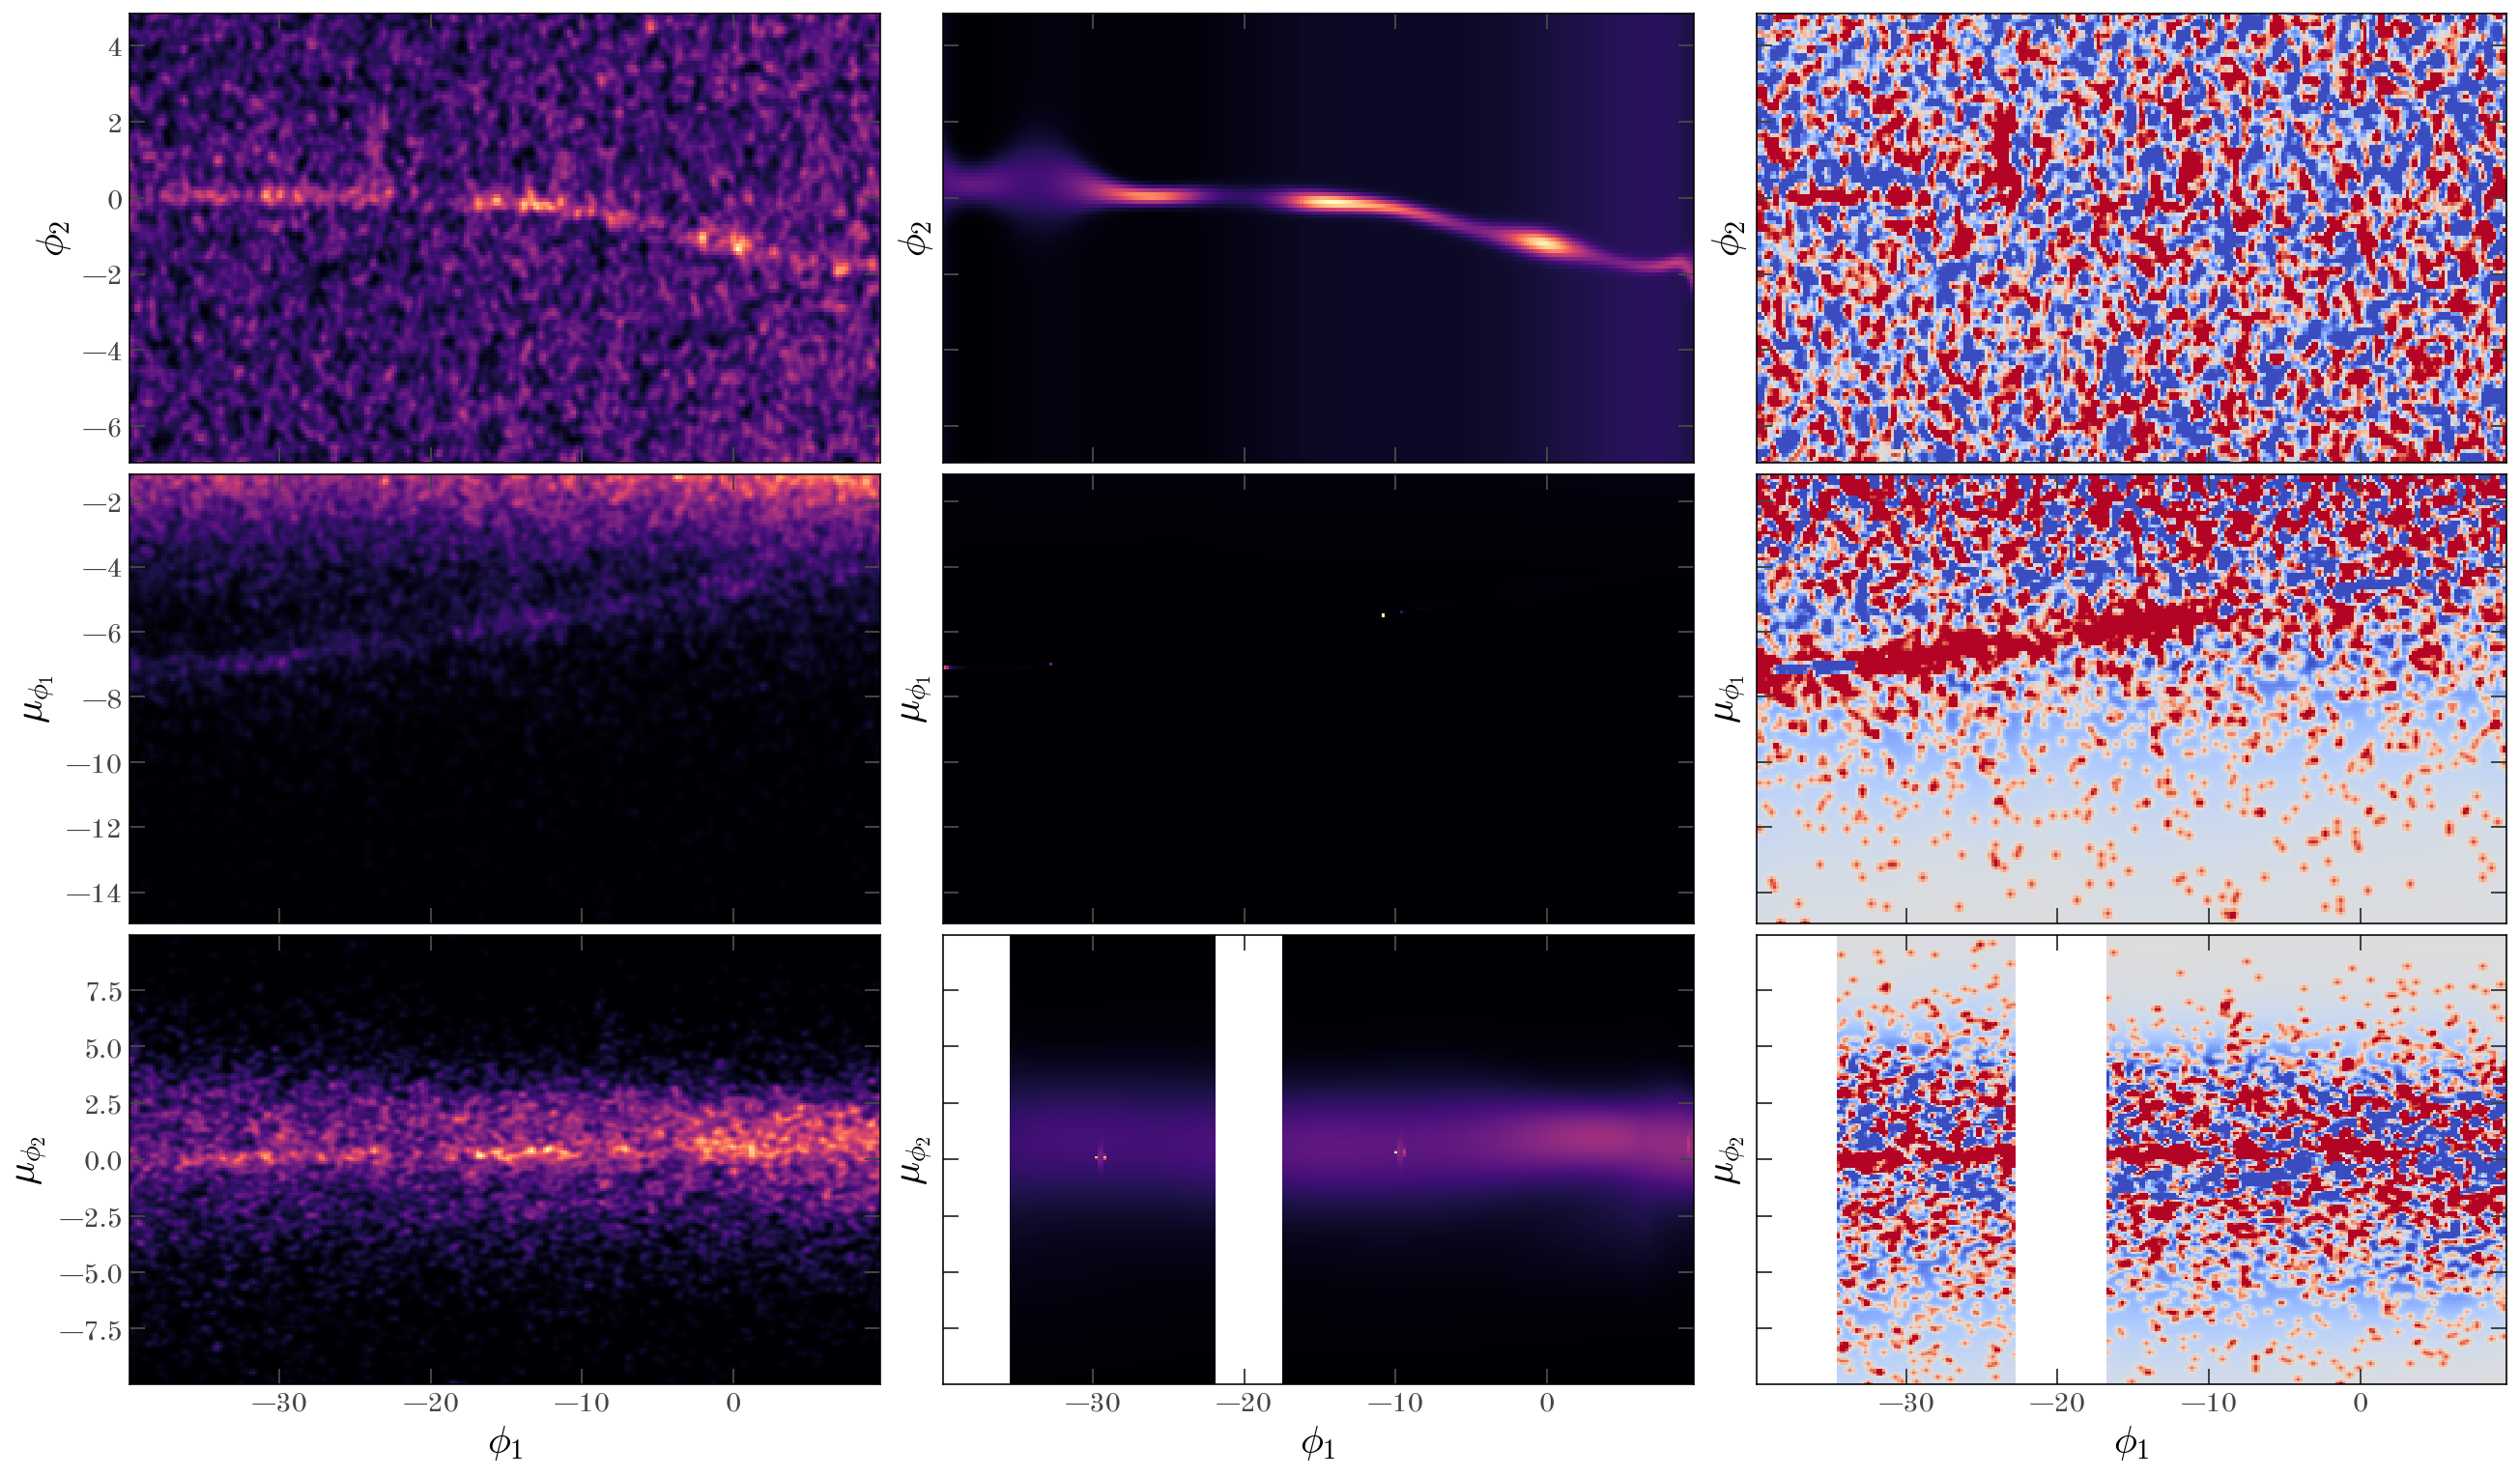

In [42]:
fig, axes = plt.subplots(
    len(mix_opt.coord_names), 
    3, 
    figsize=(18, 3.5 * len(mix_opt.coord_names)), 
    sharex=True, sharey='row', constrained_layout=True
)

axes = np.atleast_2d(axes)
mix_opt.plot_data_projections(data=run_data, axes=axes[:, 0]);
mix_opt.plot_model_projections(axes=axes[:, 1]);
mix_opt.plot_residual_projections(data=run_data, axes=axes[:, 2])
    
for ax in axes[-1]:
    ax.set_xlabel(r'$\phi_1$')

----

In [48]:
optimizer = ScipyBoundedMinimize(
    method='L-BFGS-B', 
    maxiter=2048,
    options=dict(maxls=10000),
    fun=optim_background,
)
opt_step = optimizer.run(
    init_params=bkg_init_p, 
    data=bkg_data,
    bounds=GD1BackgroundModel._get_jaxopt_bounds()
)

In [49]:
opt_step.state.success, opt_step.state.iter_num

(True, 15)

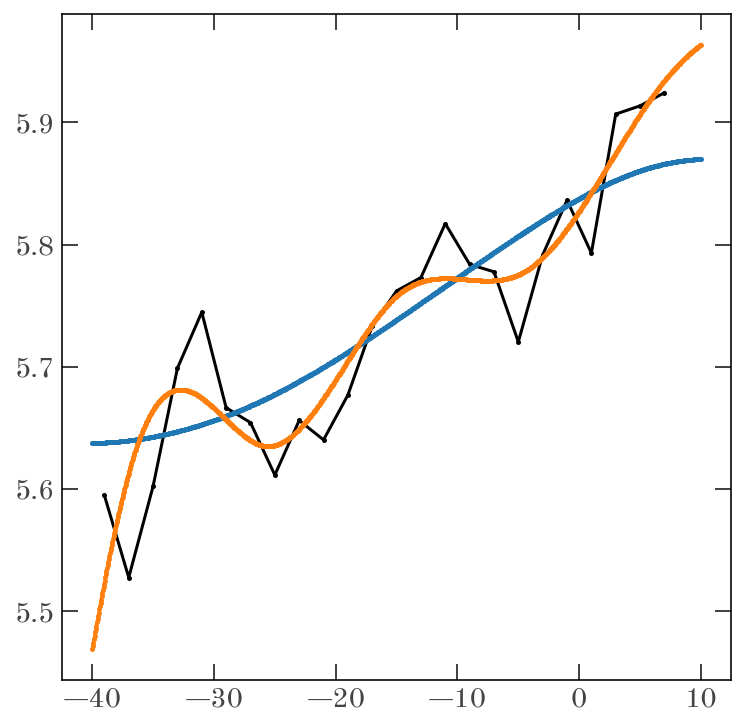

In [50]:
grid = np.linspace(*phi1_lim, 1024)
phi1_bins = np.arange(*GD1BackgroundModel.coord_bounds['phi1'], 2.)
phi1_binc = 0.5 * (phi1_bins[:-1] + phi1_bins[1:])

H, xe = np.histogram(bkg_data['phi1'], bins=phi1_bins)
plt.plot(phi1_binc, np.log(H / np.diff(phi1_bins)[0]))

spl = InterpolatedUnivariateSpline(
    GD1BackgroundModel.knots['ln_n0'],
    bkg_init_p['ln_n0'],
    GD1BackgroundModel.spline_ks['ln_n0']
)
plt.plot(grid, spl(grid))

spl = InterpolatedUnivariateSpline(
    GD1BackgroundModel.knots['ln_n0'],
    opt_step.params['ln_n0'],
    GD1BackgroundModel.spline_ks['ln_n0']
)
plt.plot(grid, spl(grid))

(<Figure size 720x288 with 1 Axes>,
 array([<AxesSubplot: ylabel='$\\phi_2$'>], dtype=object))

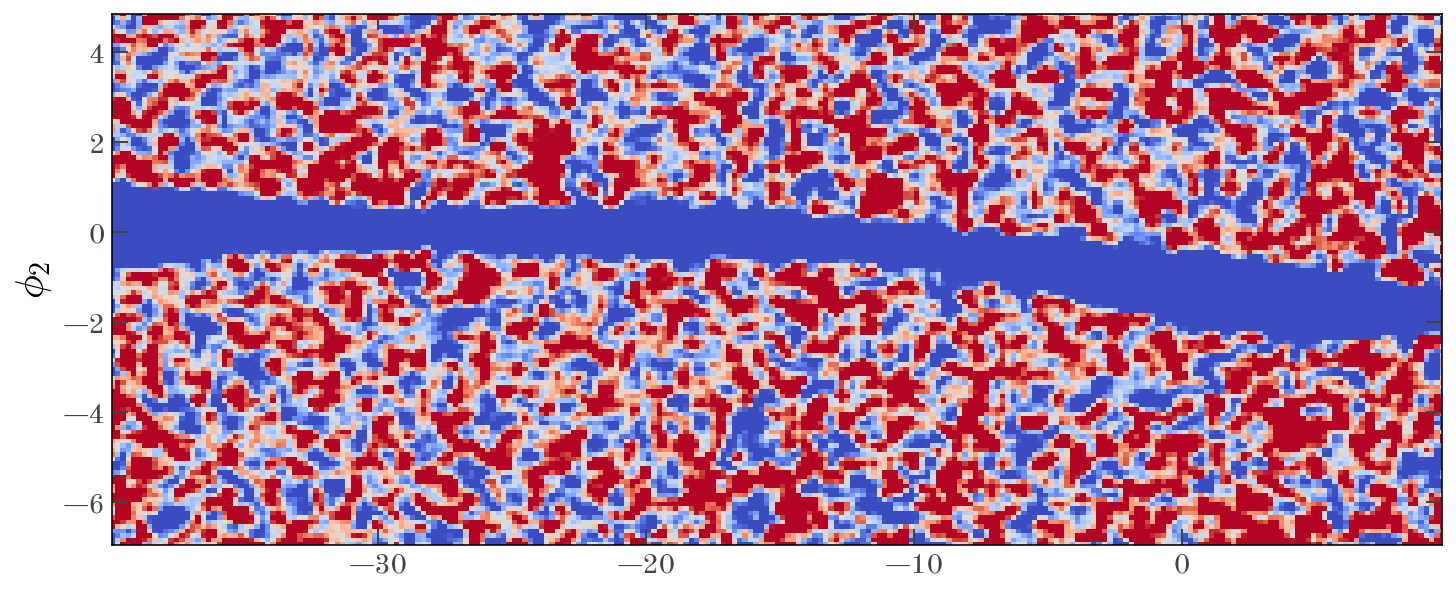

In [51]:
wtf = GD1BackgroundModel(opt_step.params)
wtf.plot_residual_projections(data=bkg_data)